<a href="https://colab.research.google.com/github/ndb796/CSED538-01/blob/master/Assignment%20%231%20-%2020192242.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Assignment #1</h2>

> 20192242 나동빈(Dongbin Na)

전체 과제는 구글 코랩(Colab) 환경에서 진행했습니다.

* [Requirement 1](#requirement1)
* [Requirement 2](#requirement2)
   * [Requirement 2-1](#requirement2-1)
   * [Requirement 2-2](#requirement2-2)
   * [Requirement 2-3](#requirement2-3)
   * [Requirement 2-4](#requirement2-4)
   * [Requirement 2-5](#requirement2-5)
* [Requirement 3](#requirement3)
* [Requirement 4](#requirement4)


### 과제 내용 시작

<a name='requirement1'>Requirement 1</a>

(20) Implement a PyTorch dataloader of the target dataset. Use 1/9 of the training dataset as a validation set, i.e., train : val : test = 8 : 1 : 1.

In [0]:
# 보스턴(Boston) 데이터 셋을 포함한 라이브러리를 불러옵니다.
from sklearn.datasets import load_boston

dataset = load_boston()

In [0]:
# 데이터 셋을 자유자재로 나누어 처리하기 위하여, 추가적으로 라이브러리를 불러옵니다.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

In [0]:
# 데이터 셋이 train : test : val = 8 : 1 : 1로 잘 나누어 졌는지 확인하기
print('Dataset Division →', len(x_train), ':', len(x_test), ':', len(x_val))

Dataset Division → 404 : 51 : 51


In [0]:
import pandas as pd

# 판다스(Pandas) 객체 초기화
df = pd.DataFrame(dataset.data)
df.columns = dataset.feature_names
df['PRICE'] = dataset.target

# 전체 데이터셋이 잘 구성되어 있는지 시각화
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


<a name='requirement2'>Requirement 2</a>

Learn linear regression models while increasing the degrees of polynomials from 1 to 3, and then discuss the results regarding the model capacity. In development, use the validation set for tuning hyperparameters and leave the test set for final evaluation.

<a name='requirement2-1'>Requirement 2-1</a>

(10) Implement the regression model using [torch.nn.module].

In [0]:
import torch

# Linear Regression 모델 정의하기
class LinearRegressionModel(torch.nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.linear = torch.nn.Linear(n_input, n_output)

    def forward(self, x):
        return self.linear(x)

<a name='requirement2-2'>Requirement 2-2</a>

(10) Train your model using the closed-form least square solver as in text book.

In [0]:
import numpy as np

# Closed Form Solution 공식을 이용하여 학습시키는 함수
def closed_form_solver(X, y):
    w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return w

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# 차수(Degree)가 1일 때부터 3일 때까지 반복하기
for degree in range(1, 4):
    poly = PolynomialFeatures(degree=degree)

    # 학습(Training) 데이터 준비하기
    x_train_poly = poly.fit_transform(x_train)
    w = closed_form_solver(x_train_poly, y_train)

    # 학습된 내용을 이용해 테스트(Test) 데이터로 평가 진행
    x_test_poly = poly.fit_transform(x_test)
    output = x_test_poly.dot(w)

    error_value = mean_squared_error(output, y_test)
    rmse = (np.sqrt(error_value))
    r2 = r2_score(output, y_test)

    print("[ Degree: " + str(degree) + "]")
    print("Test Loss:", error_value)
    print("RMSE:", rmse)
    print("R2 Score:", r2)

[ Degree: 1]
Test Loss: 29.1880246614786
RMSE: 5.402594252900971
R2 Score: 0.41322695900538964
[ Degree: 2]
Test Loss: 4.038814493754384e+24
RMSE: 2009680196885.6597
R2 Score: -0.5275425923124226
[ Degree: 3]
Test Loss: 2.686867184693467e+46
RMSE: 1.6391666128534548e+23
R2 Score: -0.02732031400219026


<a name='requirement2-3'>Requirement 2-3</a>

(10) Train your model using the gradient descent optimizer using [torch.optim].

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

learning_rate_per_degree = [5e-7, 1e-11, 1e-20]
num_epochs_per_degree = [2e5, 1e6, 2e6]

# 차수(Degree)가 1일 때부터 3일 때까지 반복하기
for degree in range(1, 4):
    poly = PolynomialFeatures(degree=degree)

    # 학습(Training) 데이터 준비하기
    x_train_poly = poly.fit_transform(x_train)

    # 크기에 맞는 입력(Input) 차원을 가지는 뉴럴 네트워크 선언
    net = LinearRegressionModel(n_input=poly.n_output_features_, n_output=1)

    # Stochastic Gradient Descent Optimizer 이용하기 (Degree에 따라서 다르게 입력)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate_per_degree[degree - 1])

    # Loss Function은 MSE(Mean Squared Error)를 이용하기
    loss_fn = torch.nn.MSELoss()

    # PyTorch를 이용해 학습하기 위해서 Tensor 객체로 변환
    x_train_torch = torch.tensor(x_train_poly, dtype=torch.float)
    y_train_torch = torch.tensor(y_train, dtype=torch.float).view(-1, 1)

    # 학습(Training) 진행하기 (Degree에 따라서 다른 학습 횟수)
    print("[ Degree: " + str(degree) + "]")
    for epoch in range(int(num_epochs_per_degree[degree - 1])):
        output = net(x_train_torch)

        # 기울기(Gradient) 값을 계산하여 가중치 갱신
        optimizer.zero_grad()
        loss = loss_fn(output, y_train_torch)
        loss.backward()
        optimizer.step()

        # 50000번의 반복(Epoch)당 한 번씩 출력
        if epoch % 50000 == 0:
            print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
    
    # 테스트(Test) 목적의 데이터 준비하기
    x_test_poly = poly.fit_transform(x_test)

    # PyTorch를 이용해 평가하기 위해서 Tensor 객체로 변환
    x_test_torch = torch.tensor(x_test_poly, dtype=torch.float)
    y_test_torch = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

    # 평가된 결과를 이용해 결과 출력
    output = net(x_test_torch).squeeze()
    target = y_test_torch.squeeze()

    error_value = mean_squared_error(list(output), list(y_test))
    rmse = (np.sqrt(error_value))
    r2 = r2_score(list(output), list(y_test))

    print("Test Loss:", error_value)
    print("RMSE:", rmse)
    print("R2 Score:", r2)

[ Degree: 1]
epoch 1 loss: 1640.1949
epoch 50001 loss: 49.4985
epoch 100001 loss: 45.4414
epoch 150001 loss: 43.3930
Test Loss: 55.78338588168387
RMSE: 7.468827610922873
R2 Score: -0.008978612073925696
[ Degree: 2]
epoch 1 loss: 219527856.0000
epoch 50001 loss: 3448.0903
epoch 100001 loss: 2153.5032
epoch 150001 loss: 1571.0432
epoch 200001 loss: 1231.1864
epoch 250001 loss: 1011.7534
epoch 300001 loss: 861.5915
epoch 350001 loss: 753.5499
epoch 400001 loss: 673.2465
epoch 450001 loss: 611.4886
epoch 500001 loss: 562.3647
epoch 550001 loss: 522.5509
epoch 600001 loss: 489.4231
epoch 650001 loss: 461.4872
epoch 700001 loss: 437.7503
epoch 750001 loss: 417.1490
epoch 800001 loss: 399.1169
epoch 850001 loss: 383.1249
epoch 900001 loss: 368.8735
epoch 950001 loss: 355.9582
Test Loss: 381.1358945006735
RMSE: 19.522702028681213
R2 Score: -0.11403248988954373
[ Degree: 3]
epoch 1 loss: 7109077893120.0000
epoch 50001 loss: 78827061248.0000
epoch 100001 loss: 70545809408.0000
epoch 150001 loss:

<a name='requirement2-4'>Requirement 2-4</a>

(20) Summarize your results in a table of the Root Mean Square Error (RMSE) values. Analyse the effect of the degrees and also compare results of the two solvers, the LS and GD solvers.

* 실험 결과를 요약한 것은 다음과 같습니다.

![image.png](https://user-images.githubusercontent.com/16822641/79583079-98691880-8107-11ea-85b6-c287cd990cbf.png)

* 실험 결과, Degree를 높이면 오히려 성능이 비약적으로 떨어지는 것을 알 수 있습니다.
* 성능이 낮게 나오는 이유로 예상되는 것은 다음과 같습니다.
    * 입력값의 일반화(Normalization)를 진행하지 않아서, 각 특징(Feature) 값을 제곱했을 때 의미 없는 값들이 존재합니다.
    * 학습 과정에서 정규화(Regularization)를 하지 않아서, 학습 과정이 매우 비효율적입니다.
* L1 및 L2 정규화를 통해 성능을 비약적으로 향상시킬 수 있을 것으로 보입니다.

<a name='requirement2-5'>Requirement 2-5</a>

(20) Identify the feature variables most highly correlated with the target variable by analyzing the results. Try your own ideas!

* Degree를 향샹시켰음에도 성능이 매우 떨어지는 점을 감안하면, 입력 값의 분포를 확인할 필요가 있습니다.
* 선형 회귀(Linear Regression) 모델의 특성상, 선형적으로 목표(Target) 값과 크게 영향력을 끼치는 일부 특징(Feature)이 있을 것입니다.
* 따라서 시각화 라이브러리를 이용하여 목표(Target)와 가장 큰 상관 관계를 가지는 특징을 찾아 볼 수 있습니다.

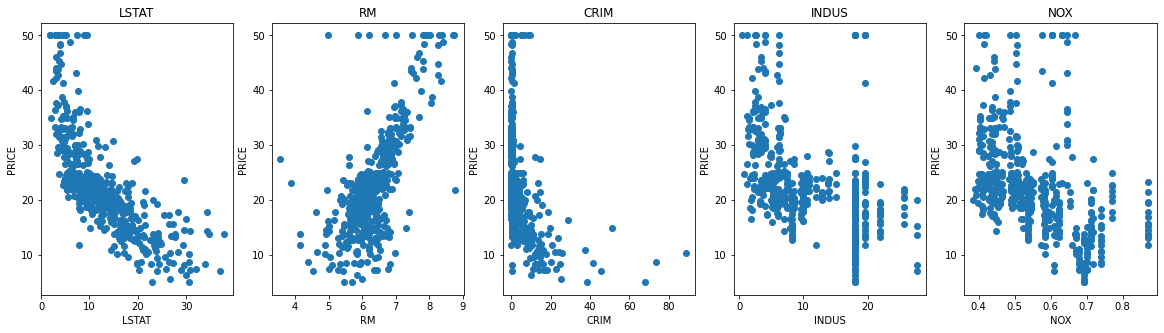

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

# 비교할 특징(Feature) 이름들
features = ['LSTAT', 'RM', 'CRIM', 'INDUS', 'NOX']
target = df['PRICE']

for i, feature in enumerate(features):
    # 여러 개의 그림으로 한 장의 이미지를 만듭니다.
    plt.subplot(1, len(features) , i + 1)

    # 각 특징(Feature)과 목표(Target) 값을 비교합니다.
    x = df[feature]
    y = target
    
    # 스캐터(Scatter) 도표를 그립니다.
    plt.scatter(x, y, marker='o')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('PRICE')

* 파이썬 시각화 라이브러리를 활용한 시각화 결과는 위 그림과 같습니다.
* RM (주택 1가구당 평균 방의 개수), LSTAT (모집단의 하위 계층 비율) 특징들이 선형적으로 밀접하게 연관성이 있는 것을 알 수 있습니다.

<a name='requirement3'>Requirement 3</a>

(20) Add some regularization terms (e.g., L2 norm, L1 norm) to your best model obtained above and redo the experiments above. How does it help?

* 차수(Degree)가 단순히 1일 때 가장 괜찮은 성능이 나온 것을 알 수 있습니다.
* 따라서 기본적인 선형 회귀(Linear Regression) 모델에 L2 정규화를 적용합니다.

In [0]:
# 학습할 뉴럴 네트워크 객체 초기화
net = LinearRegressionModel(n_input=13, n_output=1)

# PyTorch를 이용해 학습하기 위해서 Tensor 객체로 변환
x_train_torch = torch.tensor(x_train, dtype=torch.float)
y_train_torch = torch.tensor(y_train, dtype=torch.float).view(-1, 1)

# Loss Function은 MSE(Mean Squared Error)를 이용하기
loss_fn = torch.nn.MSELoss()

# 경사 하강법(Gradient Descent)를 위한 최적화 함수 선언
optimizer = torch.optim.SGD(net.parameters(), lr=0.000003)

# 학습 횟수(Epoch) 초기화
num_epochs = 200000

for epoch in range(num_epochs):
    output = net(x_train_torch)
    optimizer.zero_grad()
    loss = loss_fn(output, y_train_torch)

    # L2 정규화 손실 값을 계산합니다.
    l2_regularizer_loss = None
    for weight in net2.parameters():
        if l2_regularizer_loss is None:
            l2_regularizer_loss = weight.norm(2)
        else:
            l2_regularizer_loss = l2_regularizer_loss + weight.norm(2)
    
    # 기존의 손실 값에 더하여 가중치를 갱신합니다.
    loss += l2_regularizer_loss * 0.1
    loss.backward()
    optimizer.step()

    # 10000번의 반복(Epoch)당 한 번씩 출력
    if epoch % 10000 == 0:
        print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))

epoch 1 loss: 1247.1779
epoch 10001 loss: 46.5511
epoch 20001 loss: 42.9547
epoch 30001 loss: 41.0749
epoch 40001 loss: 39.7182
epoch 50001 loss: 38.5807
epoch 60001 loss: 37.5661
epoch 70001 loss: 36.6395
epoch 80001 loss: 35.7861
epoch 90001 loss: 34.9976
epoch 100001 loss: 34.2679
epoch 110001 loss: 33.5924
epoch 120001 loss: 32.9669
epoch 130001 loss: 32.3876
epoch 140001 loss: 31.8510
epoch 150001 loss: 31.3540
epoch 160001 loss: 30.8941
epoch 170001 loss: 30.4679
epoch 180001 loss: 30.0727
epoch 190001 loss: 29.7070


* 위 소스코드 실행 결과 RMSE 값이 많이 줄어들었습니다.
* L2 정규화를 이용하여 학습을 진행한 결과, 예측 성능이 비약적으로 좋아진 것으로 이해할 수 있습니다.
* 학습(Train)을 진행할 때의 손실 값과, 학습을 마친 뒤의 테스트(Test) 손실 값의 차이(Gap) 또한 줄어든 것이 확인됩니다.

In [0]:
# PyTorch를 이용해 평가하기 위해서 Tensor 객체로 변환
x_test_torch = torch.tensor(x_test, dtype=torch.float)
y_test_torch = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

# 평가된 결과를 이용해 결과 출력
output = net(x_test_torch).squeeze()
target = y_test_torch.squeeze()

error_value = mean_squared_error(list(output), list(y_test))
rmse = (np.sqrt(error_value))
r2 = r2_score(list(output), list(y_test))

print("Test Loss:", error_value)
print("RMSE:", rmse)
print("R2 Score:", r2)

Test Loss: 35.9383112991092
RMSE: 5.994857070782356
R2 Score: 0.2941522908014399


<a name='requirement4'>Requirement 4</a>

(20) Select the best model through the 10-fold cross-validation; (1) split the original training dataset (training+validation splits) into 10 folds, (2) conduct 10-fold crossvalidation for each hyperparameter combination, (3) select the best hyperparameter combination in terms of average validation performance over the 10 folds, (4) retrain the model with it on the original training set, and (5) evaluate the trained model on the test dataset. What difference does it make?